In [1]:
import matplotlib.pyplot as plt
import irisreader as ir
from irisreader import observation
ir.config.verbosity_level=0
import numpy as np
import os
from scipy.optimize import curve_fit
import time
import random as rdm


'''
%store -r fl_norm_X
%store -r xax_X
%store -r path_X
%store -r labels_X
%store -r t_data_X
%store -r y_data_X
%store -r fl_spectra_norm_X
%store -r centroids_X
%store -r Time_X
%store -r colors_X

fl_norm = fl_norm_X
xax = xax_X
path = path_X
labels = labels_X
t_data = t_data_X
y_data = y_data_X
fl_spectra_norm = fl_spectra_norm_X
centroids = centroids_X
Time = Time_X
colors = colors_X
'''

'''
%store -r fl_norm_M
%store -r xax_M
%store -r path_M
%store -r labels_M
%store -r t_data_M
%store -r y_data_M
%store -r fl_spectra_norm_M
%store -r centroids_M
%store -r Time_M
%store -r colors_M

fl_norm = fl_norm_M
xax = xax_M
path = path_M
labels = labels_M
t_data = t_data_M
y_data = y_data_M
fl_spectra_norm = fl_spectra_norm_M
centroids = centroids_M
Time = Time_M
colors = colors_M
'''

'''
%store -r fl_norm_C
%store -r xax_C
%store -r path_C
%store -r labels_C
%store -r t_data_C
%store -r y_data_C
%store -r y_data_C
%store -r fl_spectra_norm_C
%store -r centroids_C
%store -r Time_C
%store -r colors_C

fl_norm = fl_norm_C
xax = xax_C
path = path_C
labels = labels_C
t_data = t_data_C
y_data = y_data_C
fl_spectra_norm = fl_spectra_norm_C
centroids = centroids_C
Time = Time_C
colors = colors_C
'''




'\n%store -r fl_norm_M\n%store -r xax_M\n%store -r path_M\n%store -r labels_M\n%store -r t_data_M\n%store -r y_data_M\n%store -r fl_spectra_norm_M\n%store -r centroids_M\n%store -r Time_M\n%store -r colors_M\n\nfl_norm = fl_norm_M\nxax = xax_M\npath = path_M\nlabels = labels_M\nt_data = t_data_M\ny_data = y_data_M\nfl_spectra_norm = fl_spectra_norm_M\ncentroids = centroids_M\nTime = Time_M\ncolors = colors_M\n\n\n%store -r fl_norm_C\n%store -r xax_C\n%store -r path_C\n%store -r labels_C\n%store -r t_data_C\n%store -r y_data_C\n%store -r y_data_C\n%store -r fl_spectra_norm_C\n%store -r centroids_C\n%store -r Time_C\n%store -r colors_C\n\nfl_norm = fl_norm_C\nxax = xax_C\npath = path_C\nlabels = labels_C\nt_data = t_data_C\ny_data = y_data_C\nfl_spectra_norm = fl_spectra_norm_C\ncentroids = centroids_C\nTime = Time_C\ncolors = colors_C\n\n'

In [ ]:

def Cluster_Plotting(Clusters, N, Time, t_data, y_data, labels, n_groups):
    t_newlist = []
    y_newlist = []
    Timelist = []
    #Sort the time and positions by the cluster their spectra belongs in
    for n in range(n_groups):
        templist_t = []
        templist_y = []
        Timelist_0 = []
        for i in range(len(t_data)):
            if labels[i] == n:
                templist_t.append(t_data[i])
                templist_y.append(y_data[i])
                Timelist_0.append(Time[t_data[i]])
        t_newlist.append(templist_t)    
        y_newlist.append(templist_y)  
        Timelist.append(Timelist_0)  
    #Plot the observations only from the clusters selected 
    plt.figure(dpi=100)
    for c in range(len(Clusters)):
        n = Clusters[c]
        plt.scatter(Timelist[n], y_newlist[n], s = 3, color=colors[n], label='C'+str(n))
    plt.title('Selected spectra of flare '+str(N))
    plt.xlabel('Minutes since observation start', fontsize=15)
    plt.ylabel('Pixel', fontsize=15)
    plt.show()
    return t_newlist, y_newlist, Timelist


#X-class
Clusters = [1,2,4,5,7,8,9,11,13,14,16,17,18,19]

#M-class
#Clusters = [6,9,10,14,19]

#C-class
#Clusters = [14,22]

n_groups = int(np.max(labels))+1

index = 0
t_newlist = []
y_newlist = []
Timelist = []
N = 1
for n in range(len(t_data)):
    #Plotting the clusters and creating the lists for later plots
    t_newlist0, y_newlist0, Timelist0 = Cluster_Plotting(Clusters, N, Time[n], t_data[n], y_data[n], labels[index:index+len(t_data[n])], n_groups)
    t_newlist.append(t_newlist0)
    y_newlist.append(y_newlist0)
    Timelist.append(Timelist0)
    index = index + len(t_data[n])
    N+= 1


In [7]:


def gaussian(x, a, sig, mu, c): #Gaussian function for fitting the Magnesium 2791.56  Subordinate line
    return a * np.exp(-(x-mu)**2/(2*sig**2)) + c


def Fitting_Function(f, x_model, y_data, a0, sig0, mu0, c0):
    #Function for fitting with exception for occasional error
    try:
        var, cov = curve_fit(f, x_model, y_data, p0 = [a0, sig0, mu0, c0])
        y_model = f(x_model, var[0], var[1], var[2], var[3])
    except RuntimeError:
        var = [a0-c0 ,sig0 ,mu0 ,c0]
        y_model = f(x_model,a0-c0 ,sig0 ,mu0 ,c0)
    return y_model, var


def v_calculation(fl_norm_X, xax_X, Clusters, lambda_min, lambda_max, lambda_0, bisec_height): #Calculating the velocities using Doppler-shift
    c = 299792.458
    #Counters are to exctract certain spectra that succeded/ failed/ returned wrong results
    counter_0 = 0
    counter_1 = 0
    counter_2 = 0
    fl_min = 0
    fl_max = len(xax_X)-1
    minfound = False
    maxfound = False
    #Finding the range of xax that is bounded by lambda_min and lambda_max as well as the value of xax that corresponds to the original 2791.56 wavelength
    for i in range(len(xax_X)):
        if xax_X[i] >= lambda_min and minfound == False:
            fl_min = i
            minfound = True
        if xax_X[i] > lambda_max and maxfound == False:
            fl_max = i - 1
            maxfound = True
        if xax_X[i] <= lambda_0 and xax_X[i+1] >= lambda_0:
            m_j = i
    xax = xax_X[fl_min:fl_max]
    fl_norm = fl_norm_X
    dWL = xax[1] - xax[0]
    v = []
    error = []
    #Calculate velocities for each cluster separately
    for C in range(len(Clusters)):
        n = Clusters[C]
        v0 = []
        Sig = []
        for i in range(len(fl_norm[n])):
            minfound = False
            maxfound = False
            spectra = fl_norm[n][i][fl_min:fl_max]
            #Set root
            if np.min(spectra) >= 0:
                root = bisec_height*(np.max(spectra)-np.min(spectra)) + np.min(spectra)
            j_min = 0
            j_max = len(xax)-1
            j = 0
            #Applying bisection method and finding left and right boundries j_min and j_max
            for j in range(len(spectra)-1):
                if spectra[(j)] <= root and spectra[(j+1)] >= root and minfound == False:
                    j_min = j+1
                    minfound = True
                if spectra[(j)] >= root and spectra[(j+1)] <= root and maxfound == False:
                    j_max = j
                    maxfound = True
            mWL = (xax[j_min] + xax[j_max])/2
            #Doppler-shift calculation
            r = mWL/lambda_0
            v_0 = c*((r**2 - 1)/(r**2 + 1))
            #Ploting some spectra that succeded
            if v_0 > 0 and counter_0 < 10:
                '''
                plt.figure()
                plt.plot(xax, spectra)
                plt.scatter([xax[j_min], xax[j_max]], [root, root], color='red')
                plt.scatter([lambda_0, lambda_0], [root, root], color='orange')
                plt.scatter(mWL, root, color='green')
                plt.xlabel(r'Wavelength [$\AA$]')
                plt.ylabel('Normalized intensity')
                plt.title('Bisector method problems')
                '''
                counter_0 += 1
            #and spectra that give strange results, evaluated with a gaussian fit to correct
            if v_0 < 0:
                spectra_new, var = Fitting_Function(gaussian, xax, spectra, np.max(spectra[m_j - 10:m_j+10])-np.min(spectra[m_j - 10:m_j+10]), (xax[j_max]- xax[j_min])/2, mWL, np.min(spectra[m_j - 10:m_j+10]))
                mWL_2 = var[2]
                r = mWL_2/lambda_0
                v_0 = c*((r**2 - 1)/(r**2 + 1))
                counter_1 += 1
                if counter_1 < 5:
                    '''
                    plt.figure()
                    plt.plot(xax, spectra)
                    plt.scatter([xax[j_min], xax[j_max]], [root, root], color='red')
                    plt.scatter([lambda_0, lambda_0], [root, root], color='orange')
                    plt.scatter(mWL, root, color='green')
                    plt.xlabel(r'Wavelength [$\AA$]')
                    plt.ylabel('Normalized intensity')
                    plt.title('Bisector method problems')
                    '''
            v0.append(v_0)
            #Some spectra that still give strange results are also plotted
            if v_0 < 0:
                counter_2 += 1
                if counter_2 < 5:
                    '''
                    plt.figure()
                    plt.plot(xax, spectra)
                    plt.plot(xax, spectra_new)
                    plt.scatter(mWL, root)
                    #plt.title('n = ' +str(n) + ' i = '+str(i))
                    plt.title('Problematic spectra')
            '''
        v.append(v0) 
        error.append(Sig)   
    return v

#bisec_height = Height of bisection from 0 - 1

v = v_calculation(fl_norm, xax, Clusters, 2791.2, 2792, 2791.56, 0.6)

#v = v_calculation(fl_norm, xax, Clusters, 2791, 2792, 2791.56)



In [5]:
def v_Sorting(v, t_newlist, Clusters, index): #Sorting velocities by observation instead of clusters
    v_sort = []
    for c in range(len(Clusters)):
        n = Clusters[c]
        v_temp= v[c][int(index[0][c]):int(index[0][c])+len(t_newlist[n])]
        v_sort.append(v_temp)
        index[0][c] += len(t_newlist[n])
    return v_sort, index

v_sort = []
index = np.zeros((1,len(v)))

for t in range(len(t_newlist)):
    v_sort0, index0 = v_Sorting(v, t_newlist[t], Clusters, index)
    v_sort.append(v_sort0)
    index0 = index



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


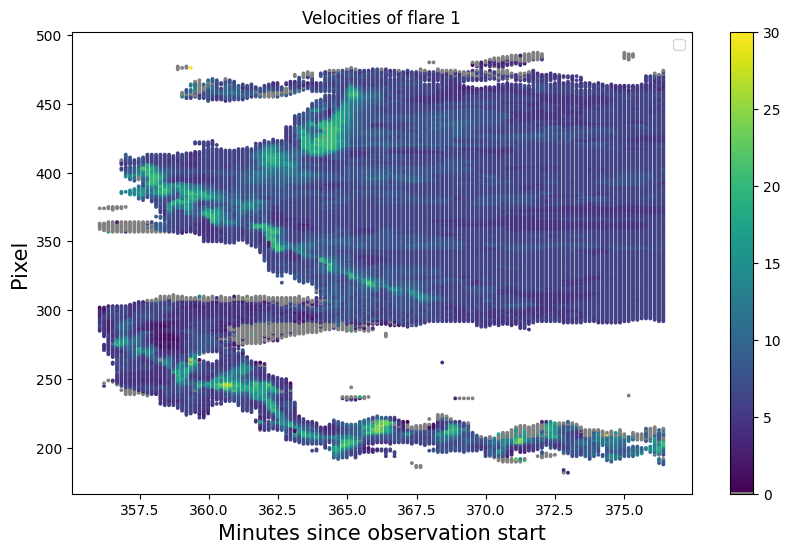

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


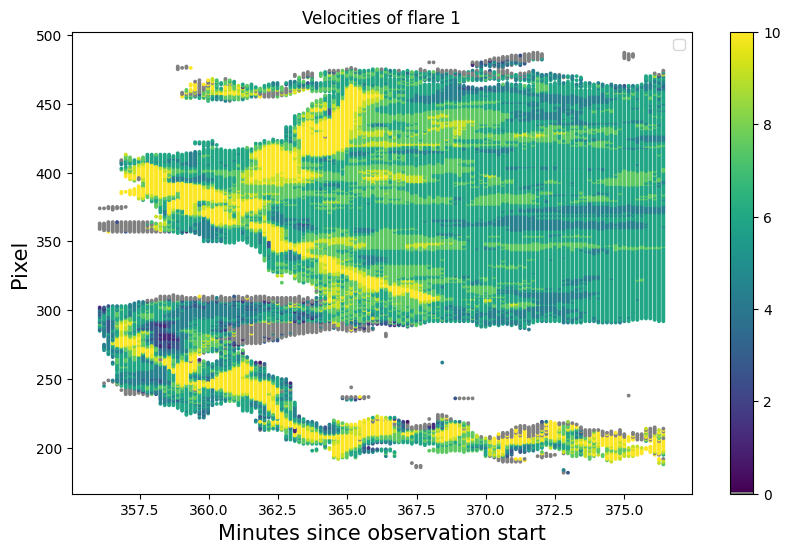

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


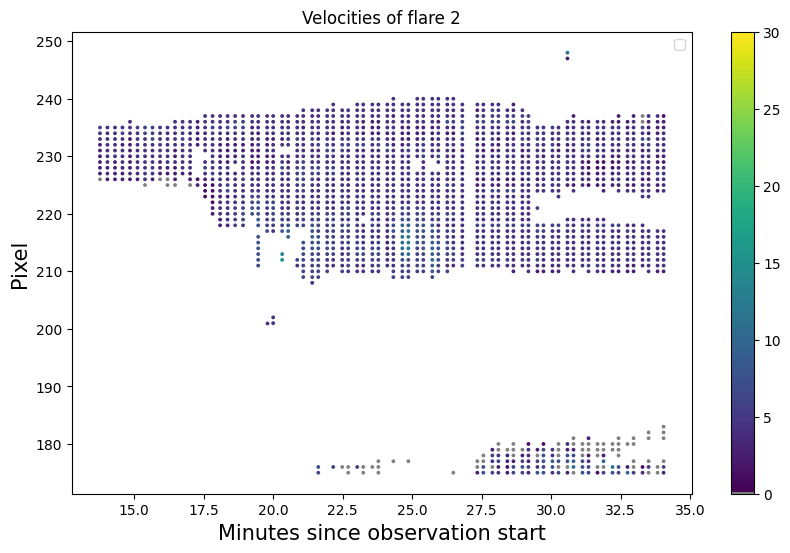

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


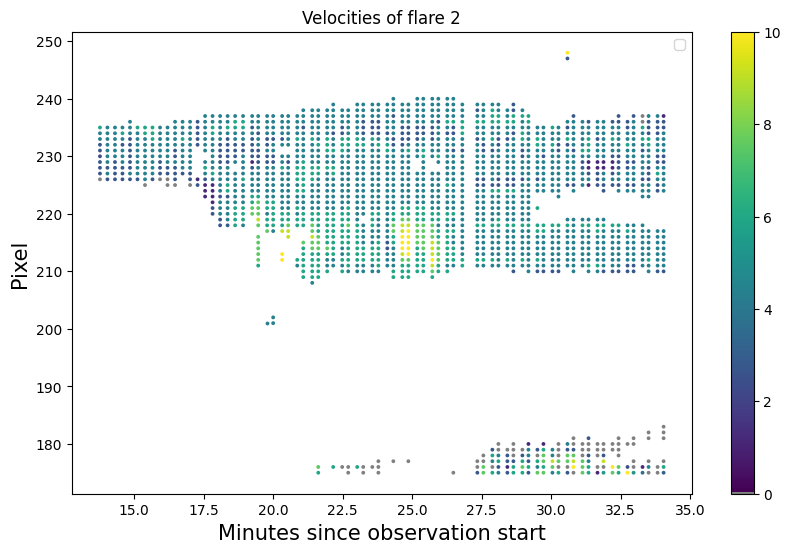

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


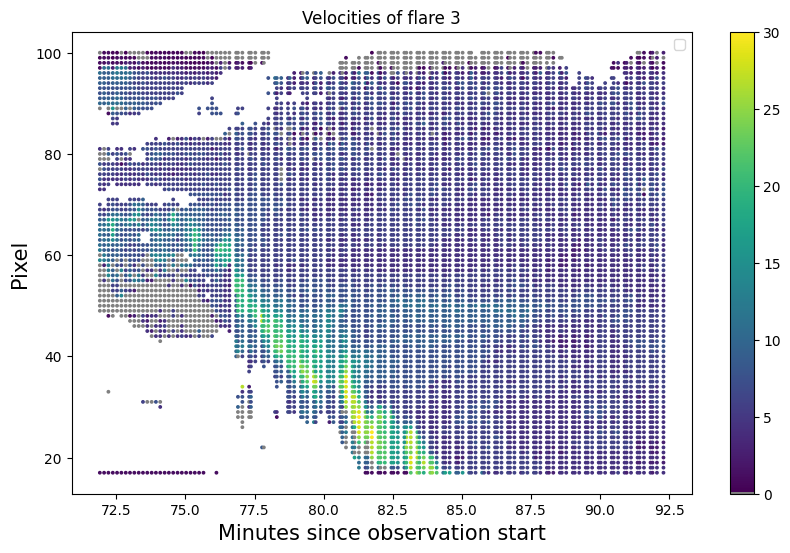

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


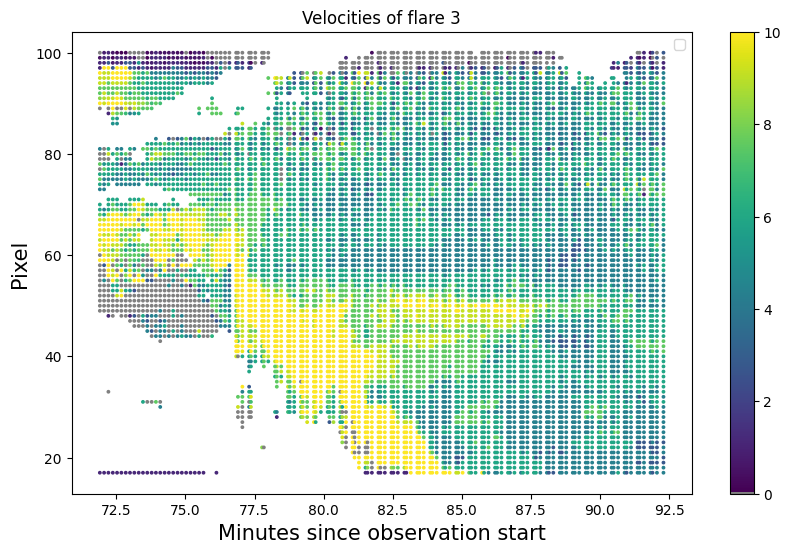

In [6]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def color_plotting(N, max, v_sort, Clusters, y_newlist, Timelist): #Plotting the velocities as a color map  
    for C in range(len(Clusters)):
        n = Clusters[C]
        viridis = plt.get_cmap('viridis', 256)
        colors = np.vstack((
            [0.5, 0.5, 0.5, 1],      # Grey for values below 0
            viridis(np.linspace(0, 1, 256))  # 'viridis' colormap
        ))
        #Creating the color map normalized to a maximum
        new_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        norm = mcolors.Normalize(vmin=0, vmax=max) 
        scatter = plt.scatter(Timelist[n], y_newlist[n], c=v_sort[C], s=3, cmap=new_cmap, norm=norm)
        if C == 0:
            plt.colorbar(scatter)
    plt.title('Velocities of flare '+str(N))
    plt.xlabel('Minutes since observation start', fontsize=15)
    plt.ylabel('Pixel', fontsize=15)
    plt.legend()
    plt.show()

#Plotting colormaps with 10 and 30 km/s maximum for more detail
N = 1
for n in range(len(t_newlist)):
    color_plotting(N, 30, v_sort[n], Clusters, y_newlist[n], Timelist[n])
    color_plotting(N, 10, v_sort[n], Clusters, y_newlist[n], Timelist[n])
    N+= 1



In [28]:
print(len(v_sort))

5


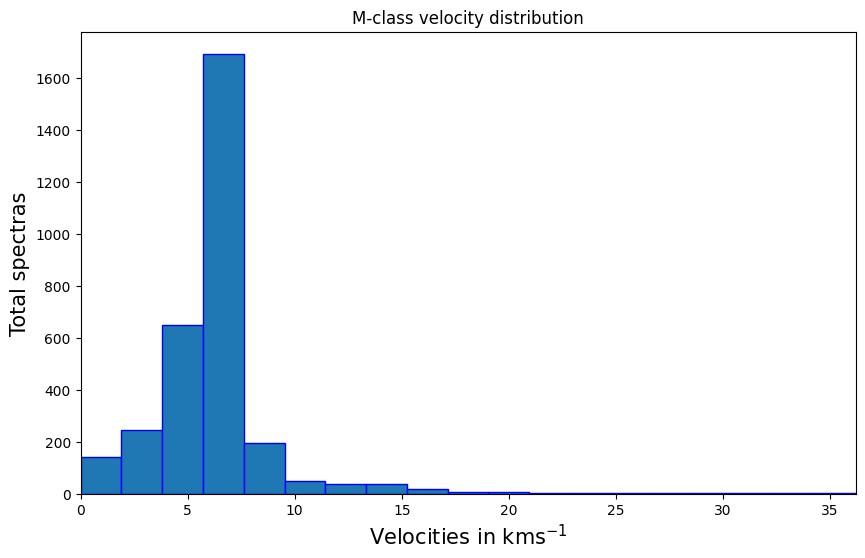

0 grösser als 30
0 kleiner als 0


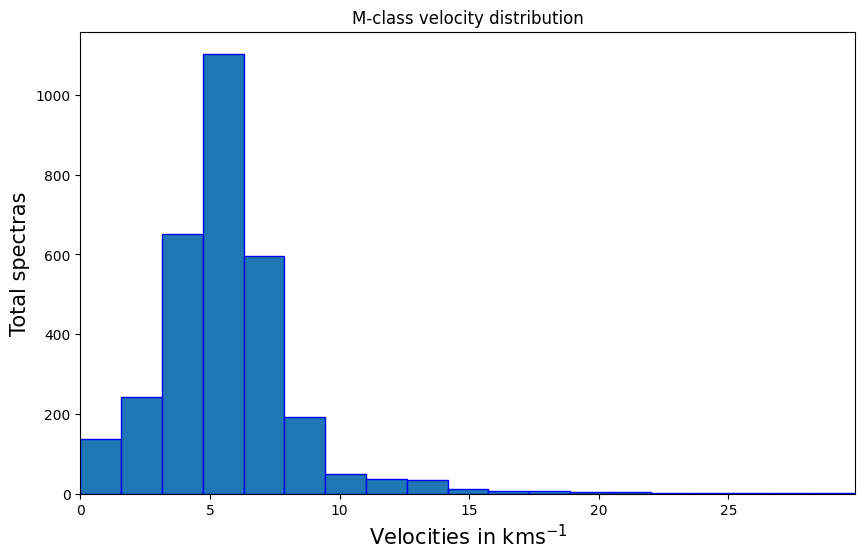

8 grösser als 30
1174 kleiner als 0
[36.18842438554537, 36.18842438554537, 36.18842438554537, 33.00360518652095, 32.8442317824761, 31.411182896386073, 31.411182896386073, 30.707247787194255, 29.897641252770075, 28.271560797864186, 27.12042278567626, 25.985614940393006, 24.680383582831297, 23.184905765934683, 21.856471488255384, 21.856471488255384, 21.02209559151724, 20.94879227633742, 20.404676230926803, 20.263989975635443, 19.916652126099812, 18.87711857681926, 18.671500002722205, 18.671500002722205, 18.671500002722205, 18.671500002722205, 18.671500002722205, 18.22724179321527, 17.07900156931599, 17.07900156931599, 17.07900156931599, 17.07900156931599, 17.07900156931599, 17.07900156931599, 17.07900156931599, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.486494675516605, 15.314242379047476, 14.313725562107098, 14.157868198259477, 13.993105767691024, 1

In [19]:
def Histogram(v, amount):
    velocity = []
    counter_max = 0
    counter_min = 0
    for n in range(len(v)):
        for c in range(len(v[n])):
            if v[n][c] >= 0:
                velocity.append(v[n][c])
    bins = np.linspace(np.min(velocity), np.max(velocity), amount)
    plt.hist(velocity, bins=bins, edgecolor='blue')
    plt.title('M-class velocity distribution')
    plt.xlabel(r'Velocities in kms$^{-1}$', fontsize=15)
    plt.ylabel('Total spectras', fontsize=15)
    plt.xlim(0, np.max(velocity))
    plt.show()
    print(str(counter_max) + ' grösser als 30')
    print(str(counter_min) + ' kleiner als 0')
    return velocity

def Histogram2(v, amount):
    velocity = []
    counter_max = 0
    counter_min = 0
    for n in range(len(v)):
        for c in range(len(v[n])):
            if v[n][c] >= 0 and v[n][c] <= 30:
                velocity.append(v[n][c])
            if v[n][c] >= 30:
                counter_max += 1
            if v[n][c] < 0:
                counter_min += 1
    bins = np.linspace(np.min(velocity), np.max(velocity), amount)
    plt.hist(velocity, bins=bins, edgecolor='blue')
    plt.title('M-class velocity distribution')
    plt.xlabel(r'Velocities in kms$^{-1}$', fontsize=15)
    plt.ylabel('Total spectras', fontsize=15)
    plt.xlim(0, np.max(velocity))
    plt.show()
    print(str(counter_max) + ' grösser als 30')
    print(str(counter_min) + ' kleiner als 0')
    return velocity


velo = Histogram(v, 20)

velo2 = Histogram2(v, 20)

velo.sort(reverse = True)
print(velo)



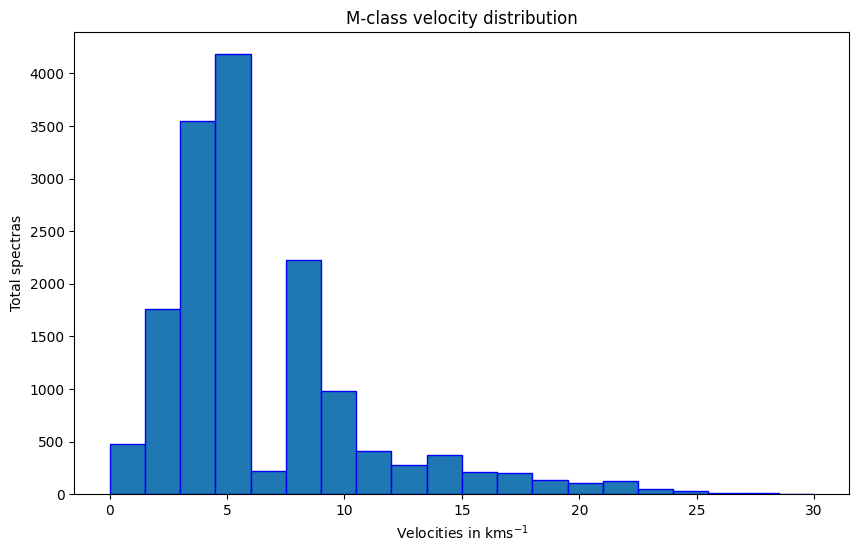

262


In [62]:
def Histogram(v):
    velocity = []
    for n in range(len(v)):
        for c in range(len(v[n])):
            #if v[n][c] >= 0:
            velocity.append(v[n][c])
    xmin = 0
    xmax = 30
    bins = 20
    plt.hist(velocity, bins=bins, edgecolor='blue', range=(xmin, xmax))
    plt.title('M-class velocity distribution')
    plt.xlabel(r'Velocities in kms$^{-1}$')
    plt.ylabel('Total spectras')
    #plt.xlim(0, 30)
    plt.show()
    return velocity

velocity = Histogram(v)

counter = 0
for i in range(len(velocity)):
    if velocity[i] >= 3 and velocity[i] <= 4:
        counter += 1
print(counter)